# Spiking Neural Networks, Part I: Neurons and Synapses

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

Note that all models described below can be solved with simple forward-Euler numerical integration.

## The leaky integrate and fire (LIF) neuron

First, construct a leaky integrate and fire neuron which follows the dynamics:
$$
\tau_m \frac{dv}{dt} = (v_{\text{rest}} - v(t)) + I(t)
$$

With the following condition for spiking
$$
v(t) = 
\begin{cases}
    v(t) & \text{if } v(t) < v_{thresh} \\
    v_{rest} & \text{otherwise, record a spike and reset}
  \end{cases}
$$


Plot the membrane voltage evolution over time of a single neuron (parameters given below). Also plot the final spike-train. **(2 points)**

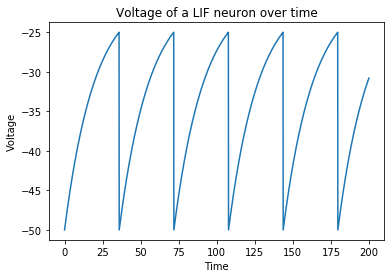

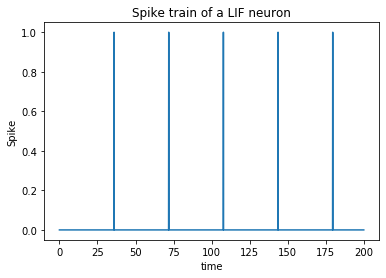

In [2]:
# Parameters
v_rest = -50.0      #mV
v_thresh = -25.0    #mV
tauM = 20.0         #ms
I = 30.0            #mV
timestep = 0.1      #ms

# Simulate for 200ms
total_time = 200.0
nb_timesteps = int(total_time / timestep)

# Initialize objects
v = np.empty(nb_timesteps)
v[0] = v_rest
spikes = np.empty(nb_timesteps)
spikes[0] = 0

for t in range(nb_timesteps-1):
    # Calculate voltage change
    dv = ((v_rest - v[t]) + I) / tauM * timestep
    
    # Spike check
    if v[t] < v_thresh:
        v[t+1] = v[t] + dv
        spikes[t+1] = 0
    else:
        v[t+1]=v_rest
        spikes[t+1] = 1

# Plot voltage
plt.plot(np.arange(0, total_time, timestep), v)
plt.title("Voltage of a LIF neuron over time")
plt.ylabel("Voltage")
plt.xlabel("Time")
plt.show()

# Plot spiketrain
plt.plot(np.arange(0, total_time, timestep), spikes)
plt.title("Spike train of a LIF neuron")
plt.ylabel("Spike")
plt.xlabel("time")
plt.show()

### The input-output curve of a LIF neuron

If there is a fixed input ($I$) to a LIF neuron it is possible to compute an analytic solution to this equation. Derive the analytic solution and plot the time to spike (from rest) of a LIF neuron across a range of inputs (range given below). **(2 point)**

D:\Programs\Anaconda\envs\nips\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
D:\Programs\Anaconda\envs\nips\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


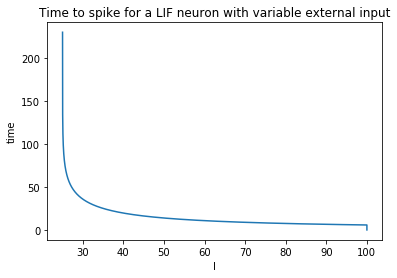

In [3]:
# Parameters
I_range = np.linspace(0,100,int(1e5))
n = len(I_range)
t = np.zeros(n)

for i in range(n-1):
    # Analytical solution for v(t) rewritten in terms of t.
    t[i] = -np.log((v_rest + I_range[i] - v_thresh) / I_range[i]) * tauM
plt.plot(I_range, t)
plt.xlabel("I")
plt.ylabel("time")
plt.title("Time to spike for a LIF neuron with variable external input")
plt.show()

Now plot the firing rate of a LIF neuron across this range (inverse of the time to spike).  **(1 point)**

D:\Programs\Anaconda\envs\nips\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


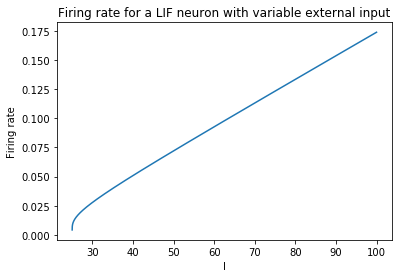

In [5]:
plt.plot(I_range, 1 / t)
plt.title("Firing rate for a LIF neuron with variable external input")
plt.ylabel("Firing rate")
plt.xlabel("I")
plt.show()

## The Hodgkin Huxley Model

Now that you have simulated a simple spiking neuron. Let us also re-produce the dynamics of a more complex neuron with the Hodgkin Huxley (HH) model.


The dynamics of the HH neuron are described

$$
C_m\frac{dv}{dt}= g_K \; n^4 \; (E_K - v) + g_{Na} \; m^3 \; h \; (E_{Na} - v) + g_L \;(E_L - v) + I
$$

where

$$
\frac{dn}{dt} = \alpha_n(1-n) - \beta_n n \\
\frac{dm}{dt} = \alpha_m(1-m) - \beta_m m \\
\frac{dh}{dt} = \alpha_h(1-h) - \beta_h h \\
$$

and the equations for the $\alpha$s and $\beta$s are given:
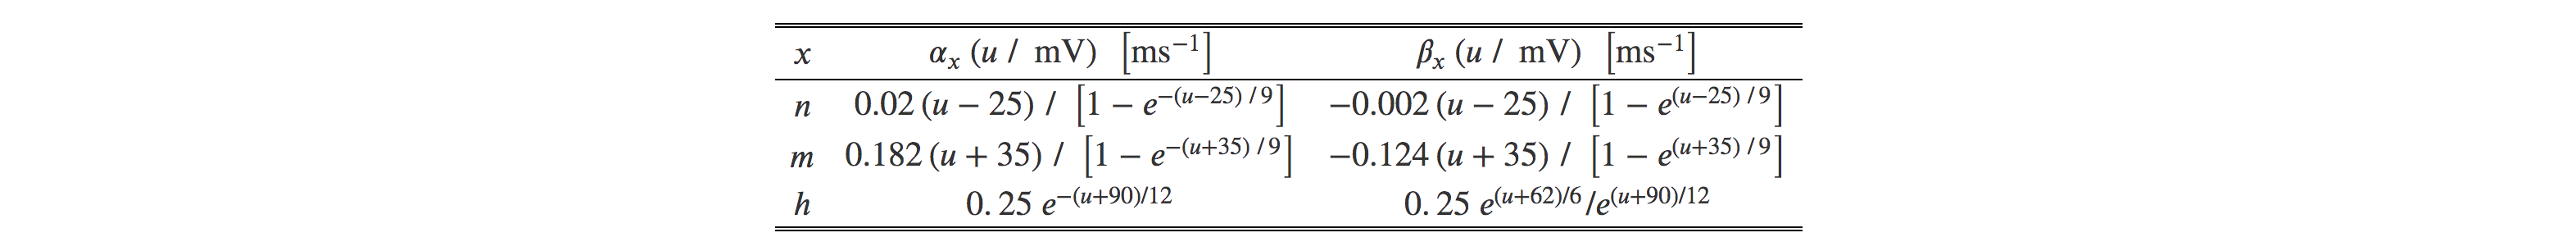

Note, to avoid strange initial dynamics you should initialize v, n, m, and h such that:
$$
v(0) = -65.0 \\
n(0) = \alpha_n(-65.0) / (\alpha_n(-65.0) + \beta_n(-65.0)) \\
m(0) = \alpha_m(-65.0) / (\alpha_m(-65.0) + \beta_m(-65.0)) \\
h(0) = \alpha_h(-65.0) / (\alpha_h(-65.0) + \beta_h(-65.0))
$$



Details extracted from the [Neuronal Dynamics Textbook](https://neuronaldynamics.epfl.ch/online/Ch2.S2.html), Chapter 2.2 (Table Above Equation 2.6).


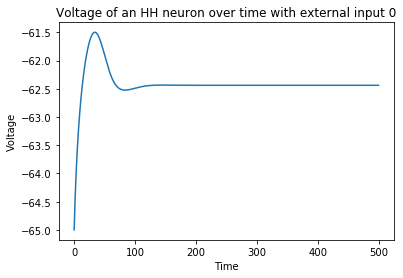

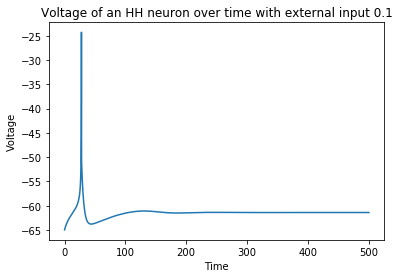

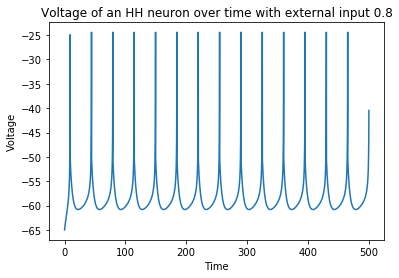

In [16]:
# The leakage, sodium, and potassium reversal potentials and maximum conductances
EL, gL = -65.0, 0.3
ENa, gNa = 55.0, 40.0
EK, gK = -77.0, 35.0
C = 1.0

# Run for 500ms
timestep = 0.01
total_time = 500.0
nb_timesteps = int(total_time / timestep)

# Define functions
def alphan(u):
    return 0.02 * (u - 25) / (1 - np.exp(-(u - 25) / 9))
def alpham(u):
    return 0.182 * (u + 35) / (1 - np.exp(-(u + 35) / 9))
def alphah(u):
    return 0.25 * np.exp(-(u + 90) / 12)

def betan(u):
    return -0.002 * (u - 25) / (1 - np.exp(u - 25) / 9)
def betam(u):
    return -0.124 * (u + 35) / (1 - np.exp(u + 35) / 9)
def betah(u):
    return 0.25 * np.exp((u + 62) / 6) / np.exp((u + 90) / 12)

def HH(I):
    # Initialize objects
    v = np.zeros(nb_timesteps)
    n = np.zeros(nb_timesteps)
    m = np.zeros(nb_timesteps)
    h = np.zeros(nb_timesteps)
    v[0] = -65.0
    n[0] = alphan(-65.0)/(alphan(-65.0) + betan(-65.0))
    m[0] = alpham(-65.0)/(alpham(-65.0) + betam(-65.0))
    h[0] = alphah(-65.0)/(alphah(-65.0) + betah(-65.0))

    for t in range(nb_timesteps-1):
        # Parameter updates
        dv = (gK * n[t]**4 * (EK - v[t]) + gNa * m[t]**3 * h[t] * (ENa - v[t]) + gL * (EL - v[t]) + I) * timestep / C
        
        # Spike check
        if v[t] < v_thresh:
            v[t+1] = v[t] + dv
            n[t+1] = n[t] + timestep * (alphan(v[t]) * (1 - n[t]) - betan(v[t]) * n[t])
            m[t+1] = m[t] + timestep * (alpham(v[t]) * (1 - m[t]) - betam(v[t]) * m[t])
            h[t+1] = h[t] + timestep * (alphah(v[t]) * (1 - h[t]) - betah(v[t]) * h[t])
        else:
            v[t+1]=v_rest
        
    # Plot voltage over time
    plt.plot(np.arange(0, total_time, timestep), v)
    plt.title("Voltage of an HH neuron over time with external input {}".format(I))
    plt.ylabel("Voltage")
    plt.xlabel("Time")
    plt.show()
    
HH(0)
HH(0.1)
HH(0.8)

Plot the voltage of a neuron with:

- sub-threshold input
- above threshold input (producing a single spike)
- above threshold input producing repeated spiking

 **(4 points)**

Also reproduce the dynamics portrait shown in the lecture (plot voltage vs time vs parameter n) for the single and multi-spike cases.  **(1 points)**
(See [this tutorial](https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html) for three-dimensional plotting).